In [1]:
# Library Importation ----------------------------------------
import pandas as pd
import xarray as xr
import numpy as np
import glob as gl
import geopandas as gpd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import numpy as np
import re
import matplotlib.ticker as mticker
import geopandas as gpd
from rasterio import features
from shapely.geometry import shape
import matplotlib.patheffects as pe
from shapely.geometry import LineString, Polygon
from shapely.ops import split
import matplotlib as mpl
from statsmodels.nonparametric.smoothers_lowess import lowess
from matplotlib.lines import Line2D
from typing import Union
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.transforms import Bbox
from pathlib import Path

In [4]:
# Function Definitions --------------------------------------
def CalculateGDD(Temp, TempBase):
    return np.where((Temp >= 0) & (Temp <= 40), np.maximum(Temp - TempBase, 0), 0)

def CalculateAccumulatedGDD(WheaterDataset, SowingDate, EndDate, OutputFolder):    
    TmeanDataset = WheaterDataset['Tmean'] # Get Mean Temperature Dataset
    TmeanDataset_MeanCycle = TmeanDataset.sel(time=slice(SowingDate, EndDate)).mean(dim='time', skipna=True)
    DateIndex = np.where(TmeanDataset['time'] == np.datetime64(SowingDate))[0][0] # Get Sowing Date Time Index
    EndIndex = np.where(TmeanDataset['time'] == np.datetime64(EndDate))[0][0] # Heading Date Time Index
    AccumulatedGDD = xr.zeros_like(TmeanDataset.isel(time=0)) # Initialize Empty Array To Store AccumulatedGDD

    TempBase = 0
    
    for i in range(DateIndex, EndIndex):
        TmeanData = TmeanDataset.isel(time=i) # Get Mean Temperature DataArray According to Date
        gdd = CalculateGDD(TmeanData, TempBase) # Calculate GDD Array
        AccumulatedGDD = AccumulatedGDD + gdd # Update AccumulatedGDD Array

    YearInfo = pd.to_datetime(TmeanData['time'].values).year # Store Year Information
    OutputDataset = xr.Dataset(
        {'AccumulatedGDD': AccumulatedGDD,
         'SowingDate': (['latitude', 'longitude'], xr.where(AccumulatedGDD > 0, np.datetime64(SowingDate), np.datetime64('NaT')).data),
         'EndDate': (['latitude', 'longitude'], xr.where(AccumulatedGDD > 0, np.datetime64(EndDate), np.datetime64('NaT')).data)},
        coords={'latitude': TmeanDataset['latitude'], 'longitude': TmeanDataset['longitude'],'time':[YearInfo]} # Construct Output Dataset
    )
    OutputDataset['SowingDate'].attrs.pop('units', None) # 
    OutputDataset.to_netcdf(f'{OutputFolder}/AccumulatedGDD_{SowingDate}_{EndDate}.nc')

    TmeanDataset_MeanCycle = xr.Dataset(
        {'Tmean_Cycle': TmeanDataset_MeanCycle,
         'SowingDate': (['latitude', 'longitude'], xr.where(AccumulatedGDD > 0, np.datetime64(SowingDate), np.datetime64('NaT')).data),
         'EndDate': (['latitude', 'longitude'], xr.where(AccumulatedGDD > 0, np.datetime64(EndDate), np.datetime64('NaT')).data)},
        coords={'latitude': TmeanDataset['latitude'], 'longitude': TmeanDataset['longitude'],'time':[YearInfo]} 
    )
    
    return OutputDataset, TmeanDataset_MeanCycle

def EstimateHeadingDate(WheaterDataset, SowingDate):    
    TmeanDataset = WheaterDataset['Tmean'] # Get Mean Temperature Dataset 
    DateIndex = np.where(TmeanDataset['time'] == np.datetime64(SowingDate))[0][0] # Get Sowing Date Time Index
    EndIndex = np.where(TmeanDataset['time'] <= np.datetime64(pd.to_datetime(TmeanDataset['time'].values[DateIndex]) + pd.DateOffset(months=10)))[0][-1] # Get 10 Months After Sowing Date Time Index

    AccumulatedGDD = xr.zeros_like(TmeanDataset.isel(time=0)) # Initialize Empty Array To Store AccumulatedGDD
    PhaseDateset = xr.zeros_like(TmeanDataset.isel(time=0), dtype=int) # Initialize Empty Array To Store Wheat Phase
    DaysToReachHeading = xr.full_like(AccumulatedGDD, np.nan) # Initialize Empty Array To Store Number Of Days Until Antese Is Reached
    DaysToReachMaturity = xr.full_like(AccumulatedGDD, np.nan)# Initialize Empty Array To Store Number Of Days Until Maturity Is Reached
    DaysToEmergence = xr.full_like(AccumulatedGDD, np.nan) # Initialize Empty Array To Store Number Of Days Until Antese Is Reached

    PhasesDict = [{'TempBase': 0, 'Threshold': 90},
                  {'TempBase': 0, 'Threshold': 1131},
                  {'TempBase': 0, 'Threshold': 2144}]
    
    for i in range(DateIndex, EndIndex):
        TmeanData = TmeanDataset.isel(time=i) # Get Mean Temperature DataArray According to Date
        gdd = CalculateGDD(TmeanData, 0) 
        StopMask = AccumulatedGDD >= PhasesDict[2]['Threshold'] # Update Mask For Pixels That Have Reached Antese  
        AccumulatedGDD = xr.where(StopMask, AccumulatedGDD, AccumulatedGDD + gdd) # Update AccumulatedGDD Array
        
        for p in range(len(PhasesDict)):
            PhaseMask = (PhaseDateset == p) & (AccumulatedGDD >= PhasesDict[p]['Threshold']) # Create And Update Mask For Each Phase
            if PhaseMask.any():
                PhaseDateset = xr.where(PhaseMask, p + 1, PhaseDateset) # Update Phases Array
                PhaseDateset = xr.where(PhaseDateset >= len(PhasesDict), len(PhasesDict) - 1, PhaseDateset) # Limit Pixel Phase Update to Antese
        
        EmergenceMask = (AccumulatedGDD >= PhasesDict[0]['Threshold']) & (np.isnan(DaysToEmergence))
        DaysToEmergence = xr.where(EmergenceMask, i - DateIndex, DaysToEmergence)

        ReachedHeadingMask = (AccumulatedGDD >= PhasesDict[1]['Threshold']) & (np.isnan(DaysToReachHeading))
        DaysToReachHeading = xr.where(ReachedHeadingMask, i - DateIndex, DaysToReachHeading)

        ReachedMaturityMask = (AccumulatedGDD >= PhasesDict[2]['Threshold']) & (np.isnan(DaysToReachMaturity))
        DaysToReachMaturity = xr.where(ReachedMaturityMask, i - DateIndex, DaysToReachMaturity)

    YearInfo = pd.to_datetime(TmeanData['time'].values).year # Store Year Information
    OutputDataset = xr.Dataset(
        {'AccumulatedGDD': AccumulatedGDD,
         'DaysToReachHeading': DaysToReachHeading,
         'DaysToReachMaturity': DaysToReachMaturity,
         'DaysToEmergence': DaysToEmergence,
         'SowingDate': (['latitude', 'longitude'], xr.where(AccumulatedGDD > 0, np.datetime64(pd.to_datetime(SowingDate)), np.datetime64('NaT')).data),
         'EmergenceDate': xr.where(AccumulatedGDD > 0, pd.to_datetime(SowingDate) + DaysToEmergence.astype("timedelta64[D]"), np.datetime64('NaT')),
         'HeadingDate': xr.where(AccumulatedGDD > 0, pd.to_datetime(SowingDate) + DaysToReachHeading.astype("timedelta64[D]"), np.datetime64('NaT')),
         'MaturityDate': xr.where(AccumulatedGDD > 0, pd.to_datetime(SowingDate) + DaysToReachMaturity.astype("timedelta64[D]"), np.datetime64('NaT'))},
        coords={'latitude': TmeanDataset['latitude'], 'longitude': TmeanDataset['longitude'],'time':[YearInfo]} # Construct Output Dataset
    )
    OutputDataset['SowingDate'].attrs.pop('units', None) # 
    
    return OutputDataset

def VectorizedMonalisaRiskModel(HeadingDatesArray, WheaterDataset, time_dim='time'):
    HeadingDatesArray = HeadingDatesArray.astype('datetime64[ns]') # Read DataArray As Datetime

    ValidPixelMask = ~np.isnan(HeadingDatesArray) # Get Valid Pixels DataArray
    WB2StartDate = xr.where(ValidPixelMask, HeadingDatesArray - np.timedelta64(14, 'D'), np.datetime64('NaT')) # Create 14 days Before Heading Date DataArray
    WB2EndDate = xr.where(ValidPixelMask, HeadingDatesArray - np.timedelta64(7, 'D'), np.datetime64('NaT')) # Create 7 days Before Heading Date DataArray
    WA1EndDate = xr.where(ValidPixelMask, HeadingDatesArray + np.timedelta64(7, 'D'), np.datetime64('NaT')) # Create 7 days After Heading Date DataArray

    MeanRH = WheaterDataset['RH'].where(
        (WheaterDataset[time_dim] >= WB2StartDate) & (WheaterDataset[time_dim] < WB2EndDate)
    ).mean(dim=time_dim) # Calculate Mean Relative Humidity Between 14 To 7 days Before Heading Date DataArray
    NumDaysB22 = (WheaterDataset['Tmean'].where(
        (WheaterDataset[time_dim] >= WB2StartDate) & (WheaterDataset[time_dim] < WB2EndDate)
    ) < 22).sum(dim=time_dim) # Calculate Number Of Days With Mean Temperature Below 22ºC Between 14 To 7 days Before Heading Date DataArray
    SumPr = WheaterDataset['pr'].where(
        (WheaterDataset[time_dim] > HeadingDatesArray) & (WheaterDataset[time_dim] <= WA1EndDate)
    ).sum(dim=time_dim) # Calculate Precipitation Sum Between Heading Date To 7 days After DataArray

    RiskArray = -10.84637 + 0.16417 * MeanRH -0.32558 * NumDaysB22 + 0.06925 * SumPr # Calculate Risk DataArray
    RiskArray = np.exp(RiskArray) / (1 + np.exp(RiskArray)) # Apply Logistic Regression

    MeanRH = MeanRH.where(ValidPixelMask)
    NumDaysB22 = NumDaysB22.where(ValidPixelMask)
    SumPr = SumPr.where(ValidPixelMask)
    RiskArray = RiskArray.where(ValidPixelMask)

    return RiskArray, MeanRH, NumDaysB22, SumPr

def PrecAnalysis(DateDataset, WeatherDataset, CN=75, re_cap=np.inf):
    SowingDateArray = DateDataset['SowingDate'].astype('datetime64[ns]')
    MaturityDateArray = DateDataset['MaturityDate'].astype('datetime64[ns]')
    ValidPixelMask = ~np.isnan(SowingDateArray)
    PrecDataset = (WeatherDataset['pr'].where((WeatherDataset['time'] >= SowingDateArray) & (WeatherDataset['time'] <= MaturityDateArray))).astype('float32')
    PrecDataset = PrecDataset.where(ValidPixelMask)
    CNDataset = xr.where(ValidPixelMask, CN, np.nan)
    SDataset = (25400.0 / CNDataset) - 254.0
    Ia = 0.2 * SDataset
    QDataset = xr.where(PrecDataset > Ia, ((PrecDataset - Ia) ** 2) / ((PrecDataset - Ia) + SDataset), 0)
    QDataset = QDataset.clip(min=0)
    Re = (PrecDataset - QDataset).clip(min=0, max=re_cap).sum(dim='time')
    Re = Re.where(ValidPixelMask)
    
    # PrecDataset = WeatherDataset['pr'].where((WeatherDataset['time'] >= SowingDateArray) & (WeatherDataset['time'] <= MaturityDateArray)).sum(dim='time')
    # PrecDataset = (PrecDataset.where(ValidPixelMask)).astype('float32')
    
    return xr.Dataset({'EffectivePrec': Re})

def cvar_shortfall_xr(Dataset, Threshold, alpha=0.05, dim="time", fill_no_tail=np.nan):
    ValidPixelMask = ~np.isnan(Dataset['EffectivePrec'])
    ShortfallDataset = xr.where(Dataset['EffectivePrec'] < Threshold, Threshold - Dataset['EffectivePrec'], 0).rename("Shortfall")
    Quantile = ShortfallDataset.quantile(1.0 - alpha, dim=dim, skipna=True)
    tail = ShortfallDataset.where(ShortfallDataset >= Quantile)
    cvar = tail.mean(dim=dim, skipna=True)
    if fill_no_tail is not None:
        cvar = cvar.fillna(fill_no_tail)
    BinaryDrought = (Dataset['EffectivePrec'] <= Threshold).rename("Shortfall Event")
    ReabilityDataset = (Dataset['EffectivePrec'] >= Threshold).mean(dim="time")
    P_LowDataset = 1.0 - ReabilityDataset
    Result = xr.Dataset({
        'Shortfall': cvar,
        'Reliability': ReabilityDataset,
        'P-Low': P_LowDataset
    })
    Result = Result.where(ValidPixelMask.any(dim="time"), np.nan)
    BinaryDrought = BinaryDrought.where(ValidPixelMask.any(dim="time"), np.nan)
    ShortfallDataset = ShortfallDataset.where(ValidPixelMask.any(dim="time"), np.nan)
    if 'crs' in Dataset.attrs:
        Result.attrs['crs'] = Dataset.attrs['crs']
    elif 'spatial_ref' in Dataset:
        Result['spatial_ref'] = Dataset['spatial_ref']

    return Result, BinaryDrought, ShortfallDataset

def CalculateEpidemicArea(
    Dataset: Union[xr.Dataset, xr.DataArray],
    threshold: float = 0.68):

    # Ensure we work with a DataArray
    da = Dataset if isinstance(Dataset, xr.DataArray) else Dataset.to_array()

    lat = da.coords['latitude']

    # Create epidemic mask and valid-pixel mask (1 for valid, 0 for NaN)
    epidemic_mask = (da > threshold)
    valid_mask = da.notnull()

    # Helper to compute counts safely
    def _counts_for(selection_mask):
        region_da = da.where(selection_mask)            # NaN where not in region
        region_valid = int(region_da.notnull().sum().item())
        # count epidemic pixels within region: keep only where region_da > threshold
        region_epidemic = int(region_da.where(region_da > threshold).count().item())
        region_percentage = (region_epidemic / region_valid * 100.0) if region_valid > 0 else 0.0
        return region_valid, region_epidemic, region_percentage

    # Total counts (whole domain)
    total_valid = int(valid_mask.sum().item())
    total_epidemic = int(epidemic_mask.where(valid_mask).sum().item())  # ensures NaNs not counted
    total_percentage = (total_epidemic / total_valid * 100.0) if total_valid > 0 else 0.0

    lat_selector = lat > -20

    # North region (lat > lat_threshold)
    north_valid, north_epidemic, north_percentage = _counts_for(lat_selector)

    # South region (lat <= lat_threshold)
    south_valid, south_epidemic, south_percentage = _counts_for(~lat_selector)

    return {
        "total": {
            "valid_pixels": total_valid,
            "epidemic_pixels": total_epidemic,
            "percentage": float(total_percentage),
        },
        "north": {
            "valid_pixels": north_valid,
            "epidemic_pixels": north_epidemic,
            "percentage": float(north_percentage),
        },
        "south": {
            "valid_pixels": south_valid,
            "epidemic_pixels": south_epidemic,
            "percentage": float(south_percentage),
        },
        "lat_name": 'latitude',
    }

def lon_formatter(x, pos):
    """Longitude: negative→W, positive→E"""
    suffix = 'W' if x < 0 else 'E'
    return f"{abs(x):.0f}°{suffix}"

def lat_formatter(y, pos):
    """Latitude: negative→S, positive→N"""
    suffix = 'S' if y < 0 else 'N'
    return f"{abs(y):.0f}°{suffix}"

def scatter_with_regression(ax, x, y, xlabel='Observed', ylabel='Estimated', title='',
                            point_label='Data points', fit_label_prefix='Linear fit'):
    """Plot scatter, 1:1 line, linear fit and annotate stats on the given axes."""
    # Convert to float numpy arrays
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)

    if x.size == 0 or y.size == 0:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center')
        return None

    # Basic stats (safe)
    try:
        pearson_r = np.corrcoef(x, y)[0, 1]
    except Exception:
        pearson_r = np.nan
    rmse = np.sqrt(np.mean((y - x) ** 2))

    # Fit linear regression, guard against degenerate cases
    slope, intercept = np.nan, np.nan
    fit_x = None
    try:
        if x.size >= 2 and np.nanstd(x) > 0:
            slope, intercept = np.polyfit(x, y, 1)
            fit_x = np.array([np.nanmin(x), np.nanmax(x)])
            fit_y = slope * fit_x + intercept
        else:
            # fallback: fit horizontal line at mean(y) if x has no variance
            slope, intercept = 0.0, float(np.nanmean(y))
            fit_x = np.array([np.nanmin(x), np.nanmax(x)])
            fit_y = np.full_like(fit_x, intercept)
    except Exception:
        fit_x, fit_y = None, None

    # Identity line extents
    finite_x = x[np.isfinite(x)]
    finite_y = y[np.isfinite(y)]
    if finite_x.size == 0 or finite_y.size == 0:
        minv, maxv = 0.0, 1.0
    else:
        minv = min(finite_x.min(), finite_y.min())
        maxv = max(finite_x.max(), finite_y.max())

    # Plot
    ax.scatter(x, y, alpha=0.85, edgecolor='k', linewidth=0.35, s=60, label=point_label)
    ax.plot([minv, maxv], [minv, maxv], linestyle='--', linewidth=1.2, label='Perfect correlation (y = x)')
    if fit_x is not None:
        ax.plot(fit_x, fit_y, linestyle='-', linewidth=1.5,
                label=f'{fit_label_prefix}: y = {slope:.3f}x + {intercept:.2f}')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xlim(minv - 1, maxv + 1)
    ax.set_ylim(minv - 1, maxv + 1)
    ax.set_aspect('equal', adjustable='box')
    ax.grid(True, linestyle=':', linewidth=0.6)
    ax.legend(loc='best', fontsize='small')

    # Annotate stats in corner
    txt = (f'N = {len(x)}\n'
           f'Pearson r = {pearson_r:.3f}\n'
           f'RMSE = {rmse:.2f} days\n'
           f'Slope = {slope:.3f}\n'
           f'Intercept = {intercept:.2f}')
    ax.text(0.02, 0.98, txt, transform=ax.transAxes,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.85))

    return {'pearson_r': pearson_r, 'rmse': rmse, 'slope': slope, 'intercept': intercept}

def make_cbar_ax(fig, axes_array, row_start, row_end, col_index, shrink=1):
    # bounding box of the rows in the target column (data column positions)
    pos_list = [axes_array[r, col_index].get_position() for r in range(row_start, row_end)]
    y0 = min(p.y0 for p in pos_list)
    y1 = max(p.y0 + p.height for p in pos_list)
    total_h = y1 - y0

    col_pos = axes_array[row_start, col_index].get_position()
    x0_col = col_pos.x0
    width = col_pos.width

    new_h = total_h * float(shrink)
    new_y0 = y0 + (total_h - new_h) / 2.0

    return fig.add_axes([x0_col, new_y0, width, new_h])

In [ ]:
# Auxiliary Varaibles Declaration -----------------------------------------------
BaseFolder = Path().resolve()

PatosDeMinasTrialsSowingDateList = ['2013-02-18','2013-02-25','2013-03-04','2013-03-11','2013-03-18','2013-03-25','2013-04-01','2013-04-08','2013-04-15',
                  '2013-04-22','2013-04-29','2013-05-06','2014-02-24','2014-03-03','2014-03-10','2014-03-17','2014-03-24','2014-03-31',
                  '2014-04-07','2014-04-14','2014-04-21','2014-04-28','2014-05-05','2014-05-12','2015-02-27','2015-03-06','2015-03-13',
                  '2015-03-20','2015-03-27','2015-04-03','2015-04-10','2015-04-17','2015-04-24','2015-05-01','2015-05-08','2015-05-15',
                  '2016-02-26','2016-03-04','2016-03-11','2016-03-18','2016-03-25','2016-04-01','2016-04-08','2016-04-15','2016-04-22',
                  '2016-04-29','2016-05-06','2016-05-13','2017-02-27','2017-03-06','2017-03-13','2017-03-20','2017-03-27','2017-04-03',
                  '2017-04-10','2017-04-17','2017-04-24','2017-05-02','2017-05-08','2017-05-15','2018-02-26','2018-03-05','2018-03-12',
                  '2018-03-19','2018-03-26','2018-04-02','2018-04-09','2018-04-16','2018-04-23','2018-04-30','2018-05-07','2018-05-14',
                  '2019-02-22','2019-03-01','2019-03-08','2019-03-15','2019-03-22','2019-03-29','2019-04-05','2019-04-12','2019-04-19',
                  '2019-04-26','2019-05-03','2019-05-10']

RoiAbove700 = gpd.read_file(f"{BaseFolder}/InputData/RoiMaskAbove700.shp")

line = LineString([(-47.47, -20.0), (-42.0, -20.0)])
LatitudeLine = gpd.GeoDataFrame({'id': [1]}, geometry=[line], crs="EPSG:4674")

Centroides = gpd.read_file(f"{BaseFolder}/InputData/MunicipiosCentroides.shp")

States = gpd.read_file(f"{BaseFolder}/InputData/BR_UF_2023.shp")
States = States[States['SIGLA_UF'].isin(['MG','GO','DF', 'BA', 'SP', 'RJ'])]
Line = gpd.read_file(f"{BaseFolder}/InputData/20LatitudeLine.shp")
 
YearList = np.arange(1961, 2023)
SowingDateList = ['-02-25','-03-05','-03-15','-03-25','-04-05','-04-15']
SowingDateList = [str(Year) + SowingDate for Year in YearList for SowingDate in SowingDateList]

C:\Users\Usuario\AppData\Local\Temp\ipykernel_20508\113696844.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  SubRoi['side'] = np.where(SubRoi.geometry.centroid.y > -20.0, 'N', 'S')


In [ ]:
# Phenological Phases Experimental Input Data (Embrapa Boletim Pre-Process) -----------------------------------------------
DatesDict = {
    2021:{'LengthHeading_0':['03-18'], 'LengthHeading_1':['03-31']},
    2020:{'LengthHeading_0':['03-13'], 'LengthHeading_1':['04-06']},
    2019:{'LengthHeading_0':['03-12'], 'LengthHeading_1':['04-03']},
    2018:{'LengthHeading_0':['03-09'], 'LengthHeading_1':['03-27']},
    2016:{'LengthHeading_0':['03-18'], 'LengthHeading_1':['04-06']}
}
map_0 = {year: v.get('LengthHeading_0', [None])[0] for year, v in DatesDict.items()}
map_1 = {year: v.get('LengthHeading_1', [None])[0] for year, v in DatesDict.items()}
TrialsDf = pd.read_csv(f"{BaseFolder}/InputData/BoletimEmprabaDateEstimation.csv", header=None)
TrialsDf.columns = ['Year','Lengths']
TrialsDf['Cultivars'] = TrialsDf['Lengths'].str.split(' ').str[0:2].apply(lambda x: "".join(x))
TrialsDf['LengthHeading_0'] = TrialsDf['Lengths'].str.split(' ').str[-4].astype(int)
TrialsDf['LengthHeading_1'] = TrialsDf['Lengths'].str.split(' ').str[-3].astype(int)
TrialsDf['LengthMaturity_0'] = TrialsDf['Lengths'].str.split(' ').str[-2].astype(int)
TrialsDf['LengthMaturity_1'] = TrialsDf['Lengths'].str.split(' ').str[-1].astype(int)
TrialsDf = TrialsDf.drop(columns=['Lengths'])
TrialsDf['SowingDate_0'] = TrialsDf['Year'].map(map_0)
TrialsDf['SowingDate_0'] = TrialsDf['Year'].astype(str) +'-' + TrialsDf['SowingDate_0'].astype(str)
TrialsDf['SowingDate_0'] = pd.to_datetime(TrialsDf['SowingDate_0'])
TrialsDf['SowingDate_1'] = TrialsDf['Year'].map(map_1)
TrialsDf['SowingDate_1'] = TrialsDf['Year'].astype(str) +'-' + TrialsDf['SowingDate_1'].astype(str)
TrialsDf['SowingDate_1'] = pd.to_datetime(TrialsDf['SowingDate_1'])
TrialsDf['HeadingDate_0'] = TrialsDf['SowingDate_0'] + pd.to_timedelta(TrialsDf['LengthHeading_0'], unit='D')
TrialsDf['HeadingDate_1'] = TrialsDf['SowingDate_1'] + pd.to_timedelta(TrialsDf['LengthHeading_1'], unit='D')
TrialsDf['MaturityDate_0'] = TrialsDf['SowingDate_0'] + pd.to_timedelta(TrialsDf['LengthMaturity_0'], unit='D')
TrialsDf['MaturityDate_1'] = TrialsDf['SowingDate_1'] + pd.to_timedelta(TrialsDf['LengthMaturity_1'], unit='D')

def melt_suffixes_to_long(df, id_vars=None):
    if id_vars is None:
        id_vars = ['Year', 'Cultivars']

    df2 = df.copy()
    # identify suffixed columns
    pattern = re.compile(r'(.+)_([0-9]+)$')
    suffixed = [c for c in df2.columns if pattern.match(c)]

    # melt
    melted = df2.melt(id_vars=id_vars, value_vars=suffixed,
                      var_name='var_rep', value_name='value')

    # split into base var and rep
    melted[['base', 'rep']] = melted['var_rep'].str.rsplit('_', n=1, expand=True)

    # pivot so each base is a column
    long = (melted
            .pivot_table(index=id_vars + ['rep'],
                         columns='base',
                         values='value',
                         aggfunc='first')  # 'first' because there should be a single value
            .reset_index())

    # optional: make rep numeric
    long['rep'] = long['rep'].astype(int)

    # flatten columns (pivot_table produced a MultiIndex)
    long.columns.name = None

    return long

TrialsDf = pd.read_csv(f"{BaseFolder}/InputData/BoletimEmprabaDateEstimation.csv", sep=';')
TrialsDf = melt_suffixes_to_long(TrialsDf, id_vars=['Year','Cultivars'])
TrialsDf = TrialsDf.sort_values(by=['Year', 'Cultivars'])
TrialsDf['Local'] = 'Uberaba'
TrialsDf = TrialsDf.rename(columns={'LengthHeading': 'DaysToHeading', 'LengthMaturity': 'DaysToMaturity'})
TrialsDf = TrialsDf[['Local','Cultivars', 'Year', 'SowingDate', 'HeadingDate', 'MaturityDate', 'DaysToHeading', 'DaysToMaturity']]
TrialsDf.to_csv(f"{BaseFolder}/InputData/BoletimEmprabaDateEstimation.csv", sep=';', index=False)

In [ ]:
# Phenological Phases Experimental Input Data ================================
# Boletim Embrapa ------------------------------------------------------------
# Heading --------------------------------------------------------------------
TrialsDf = pd.read_csv(f"{BaseFolder}/InputData/BoletimEmprabaDateEstimation.csv", sep=';')
date_pairs = (
    TrialsDf[['SowingDate', 'MaturityDate']]
    .dropna()
    .drop_duplicates()
    .apply(tuple, axis=1)
    .tolist()
)
WheaterDataset = xr.open_dataset(f"{BaseFolder}/InputData/XavierDataInput.nc")
AccumulatedGddFullDataset = []
MeanTempCycleFullDataset = []
for SowingDate, HeadingDate in tqdm(date_pairs):
    Dataset, MeanTempCycle = CalculateAccumulatedGDD(WheaterDataset, SowingDate, HeadingDate, f"{BaseFolder}/OutputData")
    AccumulatedGddFullDataset.append(Dataset)
    MeanTempCycleFullDataset.append(MeanTempCycle)
AccumulatedGddFullDataset = xr.concat(AccumulatedGddFullDataset, dim='time')
MeanTempCycleFullDataset = xr.concat(MeanTempCycleFullDataset, dim='time')

# Municipalitie extraction -----------------------------------------------------
MunCoords = gpd.read_file(f"{BaseFolder}/InputData/BR_Municipios_2022.shp")
MunCoords = MunCoords[(MunCoords['SIGLA_UF'].isin(['MG'])) & (MunCoords['NM_MUN'].isin(['Uberaba']))]
MunCoords['geometry'] = MunCoords.geometry.centroid
MunCoords['Latitude'] = MunCoords.geometry.y
MunCoords['Longitude'] = MunCoords.geometry.x

GddToHeadingDf = []
TmeanCycleDf = []
for idx, Mun in MunCoords.iterrows():
    val = AccumulatedGddFullDataset.sel(latitude=Mun['Latitude'], longitude=Mun['Longitude'], method='nearest').to_dataframe().reset_index()
    val['MUN'] = Mun['NM_MUN']
    GddToHeadingDf.append(val)
    val = MeanTempCycleFullDataset.sel(latitude=Mun['Latitude'], longitude=Mun['Longitude'], method='nearest').to_dataframe().reset_index()
    val['MUN'] = Mun['NM_MUN']
    TmeanCycleDf.append(val)
GddToHeadingDf = pd.concat(GddToHeadingDf)
TmeanCycleDf = pd.concat(TmeanCycleDf)
GddToHeadingDf = GddToHeadingDf.merge(TmeanCycleDf[['SowingDate', 'EndDate', 'MUN', 'Tmean_Cycle']], on=['SowingDate', 'EndDate', 'MUN'])

# Merging ---------------------------------------------------------
df1 = TrialsDf.copy()
df2 = GddToHeadingDf.copy()

df1['SowingDate'] = pd.to_datetime(df1['SowingDate']).dt.normalize()
df1['HeadingDate'] = pd.to_datetime(df1['HeadingDate']).dt.normalize()
df1['MaturityDate'] = pd.to_datetime(df1['MaturityDate']).dt.normalize()

df2['SowingDate'] = pd.to_datetime(df2['SowingDate']).dt.normalize()
df2['EndDate']     = pd.to_datetime(df2['EndDate']).dt.normalize()

df2_map = (
    df2
    .groupby(['SowingDate','EndDate','MUN'], as_index=False)
    [['AccumulatedGDD', 'Tmean_Cycle']]
    .mean()   # use mean if duplicates; change to first() if you prefer
)

df_merged = df1.merge(
    df2_map,
    left_on=['SowingDate','MaturityDate','Local'],
    right_on=['SowingDate','EndDate','MUN'],
    how='left'
).drop(columns=['EndDate','MUN'])
df_merged = df_merged.rename(columns={'AccumulatedGDD':'GDDToMaturity'})
df_merged = df_merged[['Local', 'Year', 'Cultivars', 'SowingDate', 'MaturityDate', 'GDDToMaturity', 'DaysToMaturity', 'Tmean_Cycle']]
df_merged.columns = ['site', 'year', 'cultivar', 'sowing_date', 'maturity_date', 'GDD_maturity', 'days_to_maturity', 'mean_temp_cycle']
df_merged.to_csv(f"{BaseFolder}/InputData/BoletimEmprabaMaturityPhenologicalEstimation_Input.csv", sep=';', index=False)

# Recorbe ======================================================================
# Heading =====================================================================
TrialsDf = pd.read_csv(f"{BaseFolder}/InputData/RECORBE - brusone - Página1.csv")
TrialsDf['SowingDate'] = pd.to_datetime(TrialsDf['semeadura']).dt.strftime('%Y-%m-%d')
TrialsDf['HeadingDate'] = pd.to_datetime(TrialsDf['espigamento']).dt.strftime('%Y-%m-%d')
TrialsDf['DaysToHeading'] =  TrialsDf['HD']
TrialsDf['MUN'] =  TrialsDf['local']
TrialsDf = TrialsDf[TrialsDf['MUN'].isin(['Lavras', 'São Gotardo', 'Uberaba', 'Planaltina'])]
date_pairs = (
    TrialsDf[['SowingDate', 'HeadingDate']]
    .dropna()
    .drop_duplicates()
    .apply(tuple, axis=1)
    .tolist()
)

WheaterDataset = xr.open_dataset(f"{BaseFolder}/InputData/Roi_Above_700_NasaPower_2024_2025.nc")
AccumulatedGddFullDataset = []
MeanTempCycleFullDataset = []
for SowingDate, HeadingDate in tqdm(date_pairs):
    Dataset, MeanTempCycle = CalculateAccumulatedGDD(WheaterDataset, SowingDate, HeadingDate, f"{BaseFolder}/OutputData")
    AccumulatedGddFullDataset.append(Dataset)
    MeanTempCycleFullDataset.append(MeanTempCycle)
AccumulatedGddFullDataset = xr.concat(AccumulatedGddFullDataset, dim='time')
MeanTempCycleFullDataset = xr.concat(MeanTempCycleFullDataset, dim='time')


# Municipalitie extraction -----------------------------------------------------
MunCoords = gpd.read_file(f"{BaseFolder}/InputData/BR_Municipios_2022.shp")
MunCoords = MunCoords[(MunCoords['SIGLA_UF'].isin(['MG'])) & (MunCoords['NM_MUN'].isin(['Lavras', 'São Gotardo', 'Uberaba', 'Planaltina']))]
MunCoords['geometry'] = MunCoords.geometry.centroid
MunCoords['Latitude'] = MunCoords.geometry.y
MunCoords['Longitude'] = MunCoords.geometry.x

GddToHeadingDf = []
TmeanCycleDf = []
for idx, Mun in MunCoords.iterrows():
    val = AccumulatedGddFullDataset.sel(latitude=Mun['Latitude'], longitude=Mun['Longitude'], method='nearest').to_dataframe().reset_index()
    val['MUN'] = Mun['NM_MUN']
    GddToHeadingDf.append(val)
    val = MeanTempCycleFullDataset.sel(latitude=Mun['Latitude'], longitude=Mun['Longitude'], method='nearest').to_dataframe().reset_index()
    val['MUN'] = Mun['NM_MUN']
    TmeanCycleDf.append(val)
GddToHeadingDf = pd.concat(GddToHeadingDf)
TmeanCycleDf = pd.concat(TmeanCycleDf)
GddToHeadingDf = GddToHeadingDf.merge(TmeanCycleDf[['SowingDate', 'EndDate', 'MUN', 'Tmean_Cycle']], on=['SowingDate', 'EndDate', 'MUN'])

# Merging ---------------------------------------------------------
df1 = TrialsDf.copy()
df2 = GddToHeadingDf.copy()

df1['SowingDate'] = pd.to_datetime(df1['SowingDate']).dt.normalize()
df1['HeadingDate'] = pd.to_datetime(df1['HeadingDate']).dt.normalize()

df2['SowingDate'] = pd.to_datetime(df2['SowingDate']).dt.normalize()
df2['EndDate']     = pd.to_datetime(df2['EndDate']).dt.normalize()

df2_map = (
    df2
    .groupby(['SowingDate','EndDate','MUN'], as_index=False)
    [['AccumulatedGDD', 'Tmean_Cycle']]
    .mean()   # use mean if duplicates; change to first() if you prefer
)

df_merged = df1.merge(
    df2_map,
    left_on=['SowingDate','HeadingDate','local'],
    right_on=['SowingDate','EndDate','MUN'],
    how='left'
)
df_merged = df_merged.rename(columns={'AccumulatedGDD':'GDDToHeading'})
df_merged = df_merged[['local', 'ano', 'cultivar', 'SowingDate', 'HeadingDate', 'GDDToHeading', 'DaysToHeading', 'Tmean_Cycle']]
df_merged.columns = ['site', 'year', 'cultivar', 'sowing_date', 'heading_date', 'GDD_heading', 'days_to_heading', 'mean_temp_cycle']
df_merged.to_csv(f"{BaseFolder}/InputData/RecorbePhenologicalEstimation_Input.csv", sep=';', index=False)

# Patos de Minas ======================================================================
# Heading =====================================================================
# Patos de Minas Trials Validation --------------------------------------------
TrialsDf = pd.read_csv(f"{BaseFolder}/InputData/DadosPatosDeMinas.csv")
TrialsDf = TrialsDf[TrialsDf['cultivar']!='BRS264']
TrialsDf['SowingDate'] = pd.to_datetime(TrialsDf['sowing_date']).dt.strftime('%Y-%m-%d')
TrialsDf['HeadingDate'] = pd.to_datetime(TrialsDf['heading_date']).dt.strftime('%Y-%m-%d')
TrialsDf['DaysToHeading'] = TrialsDf['heading_days'] 
TrialsDf['MUN'] = 'Patos de Minas'
TrialsDf = TrialsDf[['MUN', 'year','cultivar', 'SowingDate', 'HeadingDate', 'DaysToHeading']]

date_pairs = (
    TrialsDf[['SowingDate', 'HeadingDate']]
    .dropna()
    .drop_duplicates()
    .apply(tuple, axis=1)
    .tolist()
)
WheaterDataset = xr.open_dataset(f"{BaseFolder}/InputData/XavierDataInput.nc")
AccumulatedGddFullDataset = []
MeanTempCycleFullDataset = []
for SowingDate, HeadingDate in tqdm(date_pairs):
    Dataset, MeanTempCycle = CalculateAccumulatedGDD(WheaterDataset, SowingDate, HeadingDate, f"{BaseFolder}/OutputData")
    AccumulatedGddFullDataset.append(Dataset)
    MeanTempCycleFullDataset.append(MeanTempCycle)
AccumulatedGddFullDataset = xr.concat(AccumulatedGddFullDataset, dim='time')
MeanTempCycleFullDataset = xr.concat(MeanTempCycleFullDataset, dim='time')

# Municipalitie extraction -----------------------------------------------------
MunCoords = gpd.read_file("D:/Igor_Masters/Auxiliar/BR_Municipios_2022.shp")
MunCoords = MunCoords[(MunCoords['SIGLA_UF'].isin(['MG'])) & (MunCoords['NM_MUN'].isin(['Patos de Minas']))]
MunCoords['geometry'] = MunCoords.geometry.centroid
MunCoords['Latitude'] = MunCoords.geometry.y
MunCoords['Longitude'] = MunCoords.geometry.x

GddToHeadingDf = []
TmeanCycleDf = []
for idx, Mun in MunCoords.iterrows():
    val = AccumulatedGddFullDataset.sel(latitude=Mun['Latitude'], longitude=Mun['Longitude'], method='nearest').to_dataframe().reset_index()
    val['MUN'] = Mun['NM_MUN']
    GddToHeadingDf.append(val)
    val = MeanTempCycleFullDataset.sel(latitude=Mun['Latitude'], longitude=Mun['Longitude'], method='nearest').to_dataframe().reset_index()
    val['MUN'] = Mun['NM_MUN']
    TmeanCycleDf.append(val)
GddToHeadingDf = pd.concat(GddToHeadingDf)
TmeanCycleDf = pd.concat(TmeanCycleDf)
GddToHeadingDf = GddToHeadingDf.merge(TmeanCycleDf[['SowingDate', 'EndDate', 'MUN', 'Tmean_Cycle']], on=['SowingDate', 'EndDate', 'MUN'])

# Merging ---------------------------------------------------------
df1 = TrialsDf.copy()
df2 = GddToHeadingDf.copy()

df1['SowingDate'] = pd.to_datetime(df1['SowingDate']).dt.normalize()
df1['HeadingDate'] = pd.to_datetime(df1['HeadingDate']).dt.normalize()

df2['SowingDate'] = pd.to_datetime(df2['SowingDate']).dt.normalize()
df2['EndDate']     = pd.to_datetime(df2['EndDate']).dt.normalize()

df2_map = (
    df2
    .groupby(['SowingDate','EndDate','MUN'], as_index=False)
    [['AccumulatedGDD', 'Tmean_Cycle']]
    .mean()   # use mean if duplicates; change to first() if you prefer
)

df_merged = df1.merge(
    df2_map,
    left_on=['SowingDate','HeadingDate','MUN'],
    right_on=['SowingDate','EndDate','MUN'],
    how='left'
)
df_merged = df_merged.rename(columns={'AccumulatedGDD':'GDDToHeading'})
df_merged = df_merged[['MUN', 'year', 'cultivar', 'SowingDate', 'HeadingDate', 'GDDToHeading', 'DaysToHeading', 'Tmean_Cycle']]
df_merged.columns = ['site', 'year', 'cultivar', 'sowing_date', 'heading_date', 'GDD_heading', 'days_to_heading', 'mean_temp_cycle']
df_merged.to_csv(f"{BaseFolder}/InputData/PatosDeMinasPhenologicalEstimation_Input.csv", sep=';', index=False)

df0 = pd.read_csv(f"{BaseFolder}/InputData/BoletimEmprabaPhenologicalEstimation_Input.csv", sep=';')
df1 = pd.read_csv(f"{BaseFolder}/InputData/RecorbePhenologicalEstimation_Input.csv", sep=';')
df2 = pd.read_csv(f"{BaseFolder}/InputData/PatosDeMinasPhenologicalEstimation_Input.csv", sep=';')
df2 = pd.concat([df0, df1, df2])
df2 = df2.dropna(subset=['heading_date'])
df2.to_csv(f"{BaseFolder}/InputData/TrialsPhenologicalEstimation_Input.csv", sep=';', index=False)
df2

In [ ]:
# Phenological estimation validation ------------------------------------------------
# Data Input 
Df1 = pd.read_csv(f"{BaseFolder}/InputData/BoletimEmprabaDateEstimation.csv", sep=';')
Df1 = Df1.rename(columns={'Local':'MUN', 'SowingDate': 'SowingDate', 'HeadingDate':'HeadingDate', 'DaysToHeading': 'DaysToHeading','Cultivars':'Cultivar', 'MaturityDate':'MaturityDate', 'DaysToMaturity': 'DaysToMaturity'})
Df1 = Df1[['MUN', 'Cultivar', 'SowingDate', 'HeadingDate', 'DaysToHeading', 'MaturityDate', 'DaysToMaturity']]
Df1['SowingDate'] = pd.to_datetime(Df1['SowingDate'], errors='coerce').dt.tz_localize(None)
Df1['HeadingDate'] = pd.to_datetime(Df1['HeadingDate'], errors='coerce').dt.tz_localize(None)
Df1['MaturityDate'] = pd.to_datetime(Df1['MaturityDate'], errors='coerce').dt.tz_localize(None)

Df2 = pd.read_csv(f"{BaseFolder}/InputData/DadosPatosDeMinas.csv")
Df2['MUN'] = 'Patos de Minas'
Df2 = Df2.rename(columns={'sowing_date': 'SowingDate', 'heading_date':'HeadingDate', 'heading_days': 'DaysToHeading','cultivar':'Cultivar'})
Df2 = Df2[['MUN', 'Cultivar', 'SowingDate', 'HeadingDate', 'DaysToHeading']]
Df2['SowingDate'] = pd.to_datetime(Df2['SowingDate'], errors='coerce').dt.tz_localize(None)
Df2['HeadingDate'] = pd.to_datetime(Df2['HeadingDate'], errors='coerce').dt.tz_localize(None)

TrialsDf = pd.concat([Df1,Df2])
TrialsDf['DaysToHeading'] = (TrialsDf['HeadingDate'] - TrialsDf['SowingDate']).dt.days
TrialsDf['DaysToMaturity'] = (TrialsDf['MaturityDate'] - TrialsDf['SowingDate']).dt.days
TrialsDf['SowingDate'] = pd.to_datetime(TrialsDf['SowingDate']).dt.strftime('%Y-%m-%d')
TrialsDf['HeadingDate'] = pd.to_datetime(TrialsDf['HeadingDate']).dt.strftime('%Y-%m-%d')
TrialsDf['MaturityDate'] = pd.to_datetime(TrialsDf['MaturityDate']).dt.strftime('%Y-%m-%d')

# Heading and Maturity date estimation
WheaterDataset = xr.open_dataset(f"{BaseFolder}/InputData/XavierDataInput.nc")
for SowingDate in tqdm(TrialsDf['SowingDate'].unique()):
    HeadingDateDataset = EstimateHeadingDate(WheaterDataset, SowingDate)
    HeadingDateDataset.to_netcdf(f"{BaseFolder}/OutputData/Validation_HeandingDates_{SowingDate}.nc")
WheaterDataset.close()

# Municipalitie extraction -----------------------------------------------------
MunCoords = gpd.read_file(f"{BaseFolder}/InputData/BR_Municipios_2022.shp")
MunCoords = MunCoords[(MunCoords['SIGLA_UF'].isin(['MG'])) & (MunCoords['NM_MUN'].isin(['Uberaba', 'Patos de Minas']))]
MunCoords['geometry'] = MunCoords.geometry.centroid
MunCoords['Latitude'] = MunCoords.geometry.y
MunCoords['Longitude'] = MunCoords.geometry.x

HeadingDatesFullDataset = []
TimeIdList = []
FilePathList = sorted(gl.glob(f"{BaseFolder}/OutputData/Validation_HeandingDates*.nc"))
for FilePath in tqdm(FilePathList):
    Dataset = xr.open_dataset(FilePath)
    TimeIdList.append(FilePath.split('\\')[-1].split('_')[-1].split('.')[0])
    HeadingDatesFullDataset.append(Dataset)
HeadingDatesFullDataset = xr.concat(HeadingDatesFullDataset, dim='time')
HeadingDatesFullDataset = HeadingDatesFullDataset.assign_coords(time=TimeIdList)
Dataset = None

HeadingDatesDf = []
for idx, Mun in MunCoords.iterrows():
    val = HeadingDatesFullDataset.sel(latitude=Mun['Latitude'], longitude=Mun['Longitude'], method='nearest').to_dataframe().reset_index()
    val['MUN'] = Mun['NM_MUN']
    HeadingDatesDf.append(val)
HeadingDatesDf = pd.concat(HeadingDatesDf)
HeadingDatesDf = HeadingDatesDf[['time', 'SowingDate', 'MUN', 'DaysToReachHeading', 'DaysToReachMaturity', 'HeadingDate', 'MaturityDate', 'EmergenceDate', 'DaysToEmergence', 'AccumulatedGDD']]
HeadingDatesDf = HeadingDatesDf.sort_values(by=['SowingDate', 'time'])
HeadingDatesDf['SowingDate'] = pd.to_datetime(HeadingDatesDf['SowingDate']).dt.strftime('%Y-%m-%d')

#

# 

In [ ]:
# Epidemic Prob., Water Deficit Prob. Estimation ================================================================================
# Estimate Heading Date And Risk  -----------------------------------------------------------------------------------------------
WheaterDataset = xr.open_dataset(f"{BaseFolder}/InputData/XavierDataInput.nc")
for SowingDate in tqdm(SowingDateList):
    HeadingDateDataset = EstimateHeadingDate(WheaterDataset, SowingDate)
    HeadingDateDataset.to_netcdf(f"{BaseFolder}/OutputData/HDGDD1131_M2144_HeandingDates_{SowingDate}.nc")
WheaterDataset.close()

# Estimate Wheat Blast Risk ---------------------------------------------------------------------------------------------------
WheaterDataset = xr.open_dataset(f"{BaseFolder}/InputData/XavierDataInput.nc")
for SowingDate in tqdm(SowingDateList):
    HeadingDateDataset =  xr.open_dataset(f"{BaseFolder}/OutputData/HDGDD1131_M2144_HeandingDates_{SowingDate}.nc")
    HeadingDateArray = HeadingDateDataset['HeadingDate']
    RiskArray, MeanRH, NumDaysB22, SumPr = VectorizedMonalisaRiskModel(HeadingDateArray, WheaterDataset, time_dim='time')
    MeanRH.to_netcdf(f"{BaseFolder}/OutputData/HDGDD1131_M2144_MeanRH_{SowingDate}.nc")
    NumDaysB22.to_netcdf(f"{BaseFolder}/OutputData/HDGDD1131_M2144_NumDaysB22_{SowingDate}.nc")
    SumPr.to_netcdf(f"{BaseFolder}/OutputData/HDGDD1131_M2144_SumPr_{SowingDate}.nc")
    RiskArray.to_netcdf(f"{BaseFolder}/OutputData/HDGDD1131_M2144_Risk_{SowingDate}.nc")
WheaterDataset.close()

# Calculate Total and Effective Precipitation ---------------------------------------------------------------------------------
WeatherDataset = xr.open_dataset(f"{BaseFolder}/InputData/XavierDataInput.nc")
for SowingDate in tqdm(['-02-25','-03-05','-03-15','-03-25','-04-05','-04-15']):
    FilePathList = sorted(gl.glob(f"{BaseFolder}/OutputData/HDGDD1131_M2144_HeandingDates_*{SowingDate}.nc"))
    DatasetList = []
    TimeIdList = []
    for FilePath in FilePathList:
        TimeIdList.append(FilePath.split('\\')[-1].split('_')[-1].split('.')[0])
        DatesDataset =  xr.open_dataset(FilePath)
        TotalPrec = PrecAnalysis(DatesDataset, WeatherDataset, CN=75, re_cap=np.inf)
        DatasetList.append(TotalPrec)
    TotalPrec = xr.concat(DatasetList, dim='time')
    TimeIdList = pd.to_datetime(TimeIdList)
    TotalPrec = TotalPrec.assign_coords(time=TimeIdList)
    TotalPrec.to_netcdf(f"{BaseFolder}/OutputData/PrecSum_EffPrec_{SowingDate[1:]}.nc")
WeatherDataset.close()

# Calculate Shorfall and Defict Probability -----------------------------------------------------------------------------------------------
for SowingDate in tqdm(['-02-25','-03-05','-03-15','-03-25','-04-05','-04-15']):
    TotalPrec_EffecPrecDataset = xr.open_dataset(f"{BaseFolder}/OutputData/PrecSum_EffPrec_{SowingDate[1:]}.nc")
    PrecAnalysisDataset, BinaryDrought, ShortfallDataset = cvar_shortfall_xr(TotalPrec_EffecPrecDataset, Threshold=150, alpha=0.05, dim="time", fill_no_tail=np.nan)
    PrecAnalysisDataset = PrecAnalysisDataset.assign_coords(time=[SowingDate[1:]])
    PrecAnalysisDataset.to_netcdf(f"{BaseFolder}/OutputData/PrecAnalysisDataset_{SowingDate[1:]}.nc")
    BinaryDrought.to_netcdf(f"{BaseFolder}/OutputData/BinaryDrought_{SowingDate[1:]}.nc")
    ShortfallDataset.to_netcdf(f"{BaseFolder}/OutputData/Shortfall_{SowingDate[1:]}.nc")

# Generate Epidemic Area CSV -----------------------------------------------------------------------------------------------------------
FilePathList = sorted(gl.glob(f"{BaseFolder}/OutputData/HDGDD1131_M2144_Risk_*.nc"))
DataFrameList = []
for FilePath in tqdm(FilePathList):
    SowingDate = FilePath.split('_')[-1].split('.')[0]
    RiskDataset = xr.open_dataset(FilePath)
    EpidemicPixelPercentage = CalculateEpidemicArea(RiskDataset)
    Dataframe = pd.DataFrame({'SowingDate':[SowingDate],
                              'TotalEpidemicArea(%)':[EpidemicPixelPercentage['total']['percentage']],
                              'NorthEpidemicArea(%)':[EpidemicPixelPercentage['north']['percentage']],
                              'SouthEpidemicArea(%)':[EpidemicPixelPercentage['south']['percentage']]})
    DataFrameList.append(Dataframe)
EpidemicAreaDf = pd.concat(DataFrameList)
EpidemicAreaDf['MonthDay'] = EpidemicAreaDf['SowingDate'].str[5:]

100%|██████████| 6/6 [00:06<00:00,  1.14s/it]


In [ ]:
# Joint Probabily Calculation ========================================================================================
# Water Deficit Input ------------------------------------------------------------------------------------------------
PrecFullDataset = []
TimeIdList = []
FilePathList = sorted(gl.glob(f"{BaseFolder}/OutputData/PrecAnalysisDataset_*.nc"))
for FilePath in FilePathList:
    Dataset = xr.open_dataset(FilePath)
    TimeIdList.append(FilePath.split('\\')[-1].split('_')[-1].split('.')[0])
    PrecFullDataset.append(Dataset)
PrecFullDataset = xr.concat(PrecFullDataset, dim='time')
PrecFullDataset = PrecFullDataset.assign_coords(time=TimeIdList)
ValidMask = ~np.isnan(PrecFullDataset['P-Low'].isel(time=0))

DroughtEventFullDataset = []
TimeIdList = []
FilePathList = sorted(gl.glob(f"{BaseFolder}/OutputData/BinaryDrought_*.nc"))
for FilePath in FilePathList:
    Dataset = xr.open_dataset(FilePath)
    TimeIdList.append(FilePath.split('\\')[-1].split('_')[-1].split('.')[0])
    DroughtEventFullDataset.append(Dataset)
DroughtEventFullDataset = xr.concat(DroughtEventFullDataset, dim='time')
DroughtEventFullDataset['Shortfall Event'] = DroughtEventFullDataset['Shortfall Event'].where(ValidMask)

# Epidemic Prob. Input ---------------------------------------------------------------------------------------------
FilePathList = sorted(gl.glob(f"{BaseFolder}/OutputData/HDGDD1131_M2144_Risk_*.nc"))
RiskFullDataset = []
TimeIdList = []
for FilePath in FilePathList:
    TimeIdList.append(FilePath.split('\\')[-1].split('_')[-1].split('.')[0])
    Dataset = xr.open_dataset(FilePath)
    RiskFullDataset.append(Dataset)
RiskFullDataset = xr.concat(RiskFullDataset, dim='time')
RiskFullDataset = RiskFullDataset.assign_coords(time=TimeIdList)
RiskFullDataset['time'] = pd.to_datetime(RiskFullDataset['time'].values)
RiskFullDataset = RiskFullDataset['__xarray_dataarray_variable__'] >= 0.68
RiskFullDataset = RiskFullDataset.where(ValidMask)
Prob_RiskFullDataset = RiskFullDataset.assign_coords(time=RiskFullDataset['time'].dt.strftime('%m-%d'))
Prob_RiskFullDataset = Prob_RiskFullDataset.groupby('time').mean(dim='time', skipna=True)

# Independent Joint Prob -------------------------------------------------------------------------------------------
PrecFullDataset, Prob_RiskFullDataset = xr.align(PrecFullDataset, Prob_RiskFullDataset)
Prob_OR = 1 - (1 - Prob_RiskFullDataset) * (1 - PrecFullDataset['P-Low'])

# Empirical Joint Prob ---------------------------------------------------------------------------------------------
da1 = RiskFullDataset
da2 = DroughtEventFullDataset['Shortfall Event']
valid_mask = da1.notnull() | da2.notnull()
da1 = da1.notnull() & (da1 > 0)
da2 = da2.notnull() & (da2 > 0)
combined_event = (da1 | da2).astype(int)
md_labels = combined_event['time'].dt.strftime('%m-%d')
numerator = combined_event.groupby(md_labels).sum(dim='time')
denominator = valid_mask.groupby(md_labels).sum(dim='time')
Emp_ProbOR = numerator / denominator
Emp_ProbOR = Emp_ProbOR.where(denominator > 0)
Emp_ProbOR = Emp_ProbOR.rename({ 'strftime': 'time' })

CombinedProbDataset = xr.Dataset({
    'Prob_Ind': Prob_OR,
    'Emp_ProbOR': Emp_ProbOR})

CombinedProbDataset.to_netcdf(f"{BaseFolder}/OutputData/Xavier_ProbOR.nc")
df = CombinedProbDataset.to_dataframe().reset_index()
df = df.dropna(subset=['Emp_ProbOR'])
df.to_excel(f"{BaseFolder}/InputData/PRI_emp.xlsx", index=False)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_20508\2012057057.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


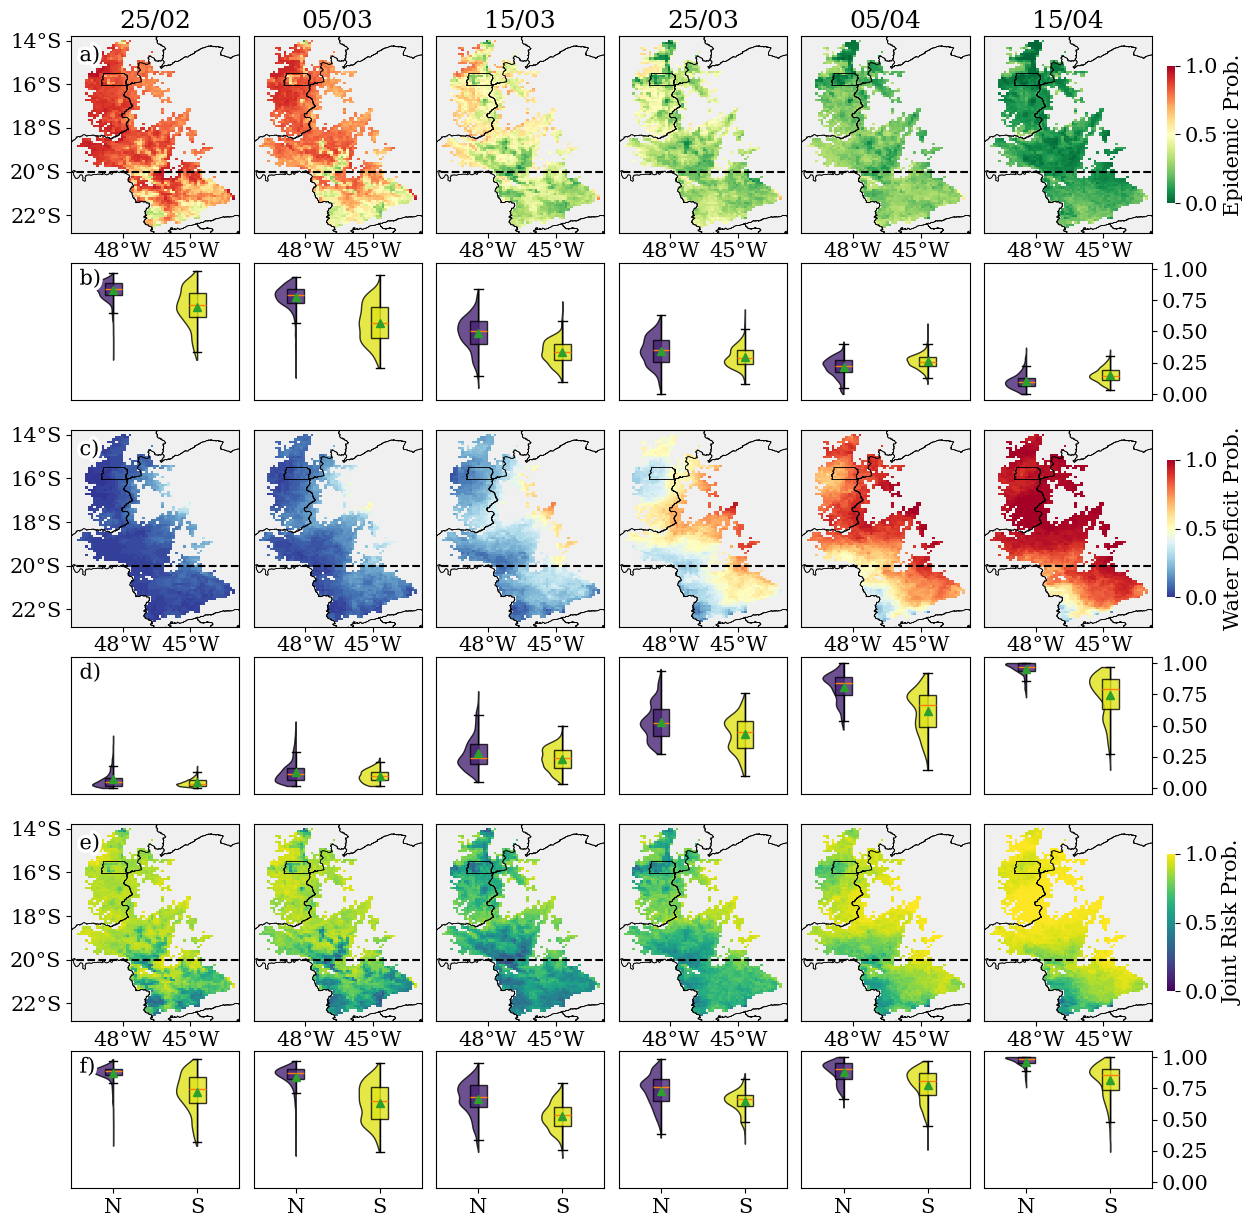

In [ ]:
# Spatial Probabilities Plots =======================================================================================================
RiskFrequencyDatasetDict = {}
for MonthDay in Prob_RiskFullDataset.time.values:
    RiskFrequencyDatasetDict[str(MonthDay)] = Prob_RiskFullDataset.sel(time=MonthDay)
WaterDefictDict = {}
for MonthDay in PrecFullDataset['P-Low'].time.values:
    WaterDefictDict[str(MonthDay)] = PrecFullDataset['P-Low'].sel(time=MonthDay)
CombinedProbDict = {}
for MonthDay in CombinedProbDataset['Emp_ProbOR'].time.values:
    CombinedProbDict[str(MonthDay)] = CombinedProbDataset['Emp_ProbOR'].sel(time=MonthDay)

HDLabel = ['25/02', '05/03', '15/03', '25/03', '05/04', '15/04']
MonthDayList = ['02-25','03-05','03-15','03-25','04-05', '04-15']
plt.rcParams.update({'font.size': 15, 'font.family': 'serif'})
cmap = cm.get_cmap('viridis')
colors = [mcolors.to_hex(cmap(0.1)), mcolors.to_hex(cmap(0.95))]

n_map_cols = len(RiskFrequencyDatasetDict.keys())
ncols = n_map_cols + 1
height_ratios = [1, 0.7, 1, 0.7, 1, 0.7]
width_ratios = [1] * n_map_cols + [0.05]

fig, axes = plt.subplots(
    6, ncols, figsize=(12, 12),
    sharex=False, sharey=False,
    constrained_layout=False,
    gridspec_kw={'height_ratios': height_ratios, 'width_ratios': width_ratios, 'hspace': 0.18, 'wspace': 0.1})

for Index, MonthDay in enumerate(RiskFrequencyDatasetDict.keys()):
    lons = RiskFrequencyDatasetDict[MonthDay]['longitude']
    lats = RiskFrequencyDatasetDict[MonthDay]['latitude']
    lon_min, lon_max = float(lons.min()), float(lons.max())
    lat_min, lat_max = float(lats.min()), float(lats.max())

    States.plot(ax=axes[0, Index], facecolor='#f0f0f0', edgecolor='none', zorder=0)
    States.plot(ax=axes[2, Index], facecolor='#f0f0f0', edgecolor='none', zorder=0)
    States.plot(ax=axes[4, Index], facecolor='#f0f0f0', edgecolor='none', zorder=0)

    Img1 = RiskFrequencyDatasetDict[MonthDay]
    Img1Plot = Img1.plot.imshow(ax=axes[0, Index], cmap="RdYlGn_r", vmin=0, vmax=1, add_colorbar=False, add_labels=False)
    Img2 = WaterDefictDict[MonthDay]
    Img2Plot = Img2.plot.imshow(ax=axes[2, Index], cmap="RdYlBu_r", vmin=0, vmax=1, add_colorbar=False, add_labels=False)
    Img3 = CombinedProbDict[MonthDay]
    Img3Plot = Img3.plot.imshow(ax=axes[4, Index], cmap="viridis", vmin=0, vmax=1,  add_colorbar=False, add_labels=False)

    axes[0, Index].set_title(HDLabel[Index])
    axes[0, Index].set_xlabel("")
    axes[0, Index].set_ylabel("")
    axes[0, Index].yaxis.set_major_locator(mticker.MultipleLocator(2))
    axes[0, Index].xaxis.set_major_formatter(mticker.FuncFormatter(lon_formatter))
    axes[0, Index].yaxis.set_major_formatter(mticker.FuncFormatter(lat_formatter))
    axes[0, Index].tick_params(labelbottom=False)
    axes[0, Index].tick_params(axis='y')
    axes[0, Index].tick_params(axis='x')
    axes[0, Index].tick_params(axis='both')
    axes[0, Index].set_xlim(lon_min-0.25, lon_max+0.25)
    axes[0, Index].set_ylim(lat_min-0.25, lat_max+0.25)

    axes[1, Index].set_xlabel("")
    axes[1, Index].set_ylabel("")
    axes[1, Index].tick_params(labelbottom=False, bottom=False)
    north = Img1.where(Img1['latitude'] > -20, drop=True)
    south = Img1.where(Img1['latitude'] < -20, drop=True)
    north_vals = north.values.ravel()
    north_vals = north_vals[~np.isnan(north_vals)]
    south_vals = south.values.ravel()
    south_vals = south_vals[~np.isnan(south_vals)]
    data_for_box = [north_vals if north_vals.size else np.array([]),
                    south_vals if south_vals.size else np.array([])]
    b = axes[1, Index].boxplot(
        data_for_box,
        tick_labels=['N', 'S'],
        showmeans=True,
        patch_artist=True,
        widths=0.2,
        showfliers=False
    )
    for patch, color in zip(b['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.8)
    vp = axes[1, Index].violinplot(
        data_for_box,
        positions=[1, 2],
        widths=0.5,
        showmeans=False,
        showmedians=False,
        showextrema=False
    )
    for i, (body, color) in enumerate(zip(vp['bodies'], colors), start=1):
        path = body.get_paths()[0]
        vertices = path.vertices
        vertices[:, 0] = np.minimum(vertices[:, 0], i)
        body.set_facecolor(color)
        body.set_edgecolor('black')
        body.set_alpha(0.8)
    axes[1, Index].set_ylim(-0.05, 1.05)
    axes[1, Index].set_yticks([0.00, 0.25, 0.50, 0.75, 1.00])
    axes[1, Index].yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))

    axes[2, Index].set_xlabel("")
    axes[2, Index].set_ylabel("")
    axes[2, Index].yaxis.set_major_locator(mticker.MultipleLocator(2))
    axes[2, Index].xaxis.set_major_formatter(mticker.FuncFormatter(lon_formatter))
    axes[2, Index].yaxis.set_major_formatter(mticker.FuncFormatter(lat_formatter))
    axes[2, Index].tick_params(labelbottom=False)
    axes[2, Index].tick_params(axis='y')
    axes[2, Index].tick_params(axis='x')
    axes[2, Index].set_xlim(lon_min-0.25, lon_max+0.25)
    axes[2, Index].set_ylim(lat_min-0.25, lat_max+0.25)
    
    axes[3, Index].set_xlabel("")
    axes[3, Index].set_ylabel("")
    axes[3, Index].tick_params(labelbottom=False, bottom=False)
    north = Img2.where(Img2['latitude'] > -20, drop=True)
    south = Img2.where(Img2['latitude'] < -20, drop=True)
    north_vals = north.values.ravel()
    north_vals = north_vals[~np.isnan(north_vals)]
    south_vals = south.values.ravel()
    south_vals = south_vals[~np.isnan(south_vals)]
    data_for_box = [north_vals if north_vals.size else np.array([]),
                    south_vals if south_vals.size else np.array([])]
    b = axes[3, Index].boxplot(
        data_for_box,
        tick_labels=['N', 'S'],
        showmeans=True,
        patch_artist=True,
        widths=0.2,
        showfliers=False
    )
    for patch, color in zip(b['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.8)
    vp = axes[3, Index].violinplot(
        data_for_box,
        positions=[1, 2],
        widths=0.5,
        showmeans=False,
        showmedians=False,
        showextrema=False
    )
    for i, (body, color) in enumerate(zip(vp['bodies'], colors), start=1):
        path = body.get_paths()[0]
        vertices = path.vertices
        vertices[:, 0] = np.minimum(vertices[:, 0], i)
        body.set_facecolor(color)
        body.set_edgecolor('black')
        body.set_alpha(0.8)
    axes[3, Index].set_ylim(-0.05, 1.05)
    axes[3, Index].set_yticks([0.00, 0.25, 0.50, 0.75, 1.00])
    axes[3, Index].yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
    
    axes[4, Index].set_xlabel("")
    axes[4, Index].set_ylabel("")
    axes[4, Index].yaxis.set_major_locator(mticker.MultipleLocator(2))
    axes[4, Index].xaxis.set_major_formatter(mticker.FuncFormatter(lon_formatter))
    axes[4, Index].yaxis.set_major_formatter(mticker.FuncFormatter(lat_formatter))
    axes[4, Index].tick_params(labelbottom=True, bottom=True)
    axes[4, Index].tick_params(axis='y')
    axes[4, Index].tick_params(axis='x')
    axes[4, Index].set_xlim(lon_min-0.25, lon_max+0.25)
    axes[4, Index].set_ylim(lat_min-0.25, lat_max+0.25)

    axes[5, Index].set_xlabel("")
    axes[5, Index].set_ylabel("")
    axes[5, Index].tick_params(labelbottom=True)
    north = Img3.where(Img3['latitude'] > -20, drop=True)
    south = Img3.where(Img3['latitude'] < -20, drop=True)
    north_vals = north.values.ravel()
    north_vals = north_vals[~np.isnan(north_vals)]
    south_vals = south.values.ravel()
    south_vals = south_vals[~np.isnan(south_vals)]
    data_for_box = [north_vals if north_vals.size else np.array([]),
                    south_vals if south_vals.size else np.array([])]
    b = axes[5, Index].boxplot(
        data_for_box,
        tick_labels=['N', 'S'],
        showmeans=True,
        patch_artist=True,
        widths=0.2,
        showfliers=False
    )
    for patch, color in zip(b['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.8)
    vp = axes[5, Index].violinplot(
        data_for_box,
        positions=[1, 2],
        widths=0.5,
        showmeans=False,
        showmedians=False,
        showextrema=False
    )
    for i, (body, color) in enumerate(zip(vp['bodies'], colors), start=1):
        path = body.get_paths()[0]
        vertices = path.vertices
        vertices[:, 0] = np.minimum(vertices[:, 0], i)
        body.set_facecolor(color)
        body.set_edgecolor('black')
        body.set_alpha(0.8)
    axes[5, Index].set_ylim(-0.05, 1.05)
    axes[5, Index].set_yticks([0.00, 0.25, 0.50, 0.75, 1.00])
    axes[5, Index].yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))

    States.boundary.plot(ax=axes[0, Index], color='black', linewidth=0.5)
    States.boundary.plot(ax=axes[2, Index], color='black', linewidth=0.5)
    States.boundary.plot(ax=axes[4, Index], color='black', linewidth=0.5)

    Line.plot(ax=axes[0, Index], color='black', linestyle='--')
    Line.plot(ax=axes[2, Index], color='black', linestyle='--')
    Line.plot(ax=axes[4, Index], color='black', linestyle='--')

    if Index==5:
        axes[0, Index].tick_params(labelleft=False, left=False, labelbottom=True, bottom=True)
        axes[1, Index].tick_params(labelleft=False, labelright=True)
        axes[1, Index].yaxis.set_ticks_position('right')
        axes[1, Index].yaxis.set_label_position("right")
        axes[2, Index].tick_params(labelleft=False, left=False, labelbottom=True, bottom=True)
        axes[3, Index].tick_params(labelleft=False, labelright=True)
        axes[3, Index].yaxis.set_ticks_position('right')
        axes[3, Index].yaxis.set_label_position("right")
        axes[4, Index].tick_params(labelleft=False, left=False, labelbottom=True, bottom=True)
        axes[5, Index].tick_params(labelleft=False, labelright=True)
        axes[5, Index].yaxis.set_ticks_position('right')
        axes[5, Index].yaxis.set_label_position("right")
    elif Index==0:
        axes[0, Index].tick_params(labelleft=True, left=True, labelbottom=True, bottom=True)
        axes[1, Index].tick_params(labelleft=False, left=False, bottom=False)
        axes[2, Index].tick_params(labelleft=True, left=True, labelbottom=True, bottom=True)
        axes[3, Index].tick_params(labelleft=False, left=False, bottom=False)
        axes[4, Index].tick_params(labelleft=True, left=True, labelbottom=True, bottom=True)
        axes[5, Index].tick_params(labelleft=False, left=False)
    else:
        axes[0, Index].tick_params(labelleft=False, left=False, labelbottom=True, bottom=True)
        axes[1, Index].tick_params(labelleft=False, left=False, bottom=False)
        axes[2, Index].tick_params(labelleft=False, left=False, labelbottom=True, bottom=True)
        axes[3, Index].tick_params(labelleft=False, left=False, bottom=False)
        axes[4, Index].tick_params(labelleft=False, left=False, labelbottom=True, bottom=True)
        axes[5, Index].tick_params(labelleft=False, left=False)

labels = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)']
for i, lbl in enumerate(labels):
    axes[i, 0].text(
        0.05, 0.95, lbl,
        transform=axes[i, 0].transAxes,
        va='top', ha='left',
        color='black',
        bbox=dict(facecolor='none', edgecolor='none', pad=0)
    ).set_path_effects([pe.withStroke(linewidth=5, foreground='white')])

plt.subplots_adjust(left=0.03, right=0.95, top=0.98, bottom=0.02, wspace=0.1, hspace=0.1)
for col in range(n_map_cols):
    for map_row in (0, 2, 4):
        axes[map_row, col].set_aspect('auto')

fig.canvas.draw()
for row in range(6):
    pos_list = [axes[row, col].get_position() for col in range(n_map_cols)]
    min_y0 = min(p.y0 for p in pos_list)
    max_y1 = max(p.y0 + p.height for p in pos_list)
    new_height = max_y1 - min_y0
    for col in range(n_map_cols):
        p = axes[row, col].get_position()
        axes[row, col].set_position([p.x0, min_y0, p.width, new_height])

col_cbar = -1
# turn off the original small axes in the colorbar column
for r in range(6):
    axes[r, col_cbar].axis('off')

cax1 = make_cbar_ax(fig, axes, 0, 1, col_cbar, shrink=0.7)
cax2 = make_cbar_ax(fig, axes, 2, 3, col_cbar, shrink=0.7)
cax3 = make_cbar_ax(fig, axes, 4, 5, col_cbar, shrink=0.7)

# add colorbars into those dedicated axes (single Axes each)
cb1 = fig.colorbar(Img1Plot, cax=cax1, orientation='vertical')
cb1.outline.set_visible(False)
cb1.set_label("Epidemic Prob.")

cb2 = fig.colorbar(Img2Plot, cax=cax2, orientation='vertical')
cb2.outline.set_visible(False)
cb2.set_label("Water Deficit Prob.")

cb3 = fig.colorbar(Img3Plot, cax=cax3, orientation='vertical')
cb3.outline.set_visible(False)
cb3.set_label("Joint Risk Prob.")

fig.canvas.draw()

plt.savefig(f"{BaseFolder}/OutputData/WHB_Drought_JointProb.png", dpi=600, bbox_inches='tight', pad_inches=0.01)
plt.show()

In [8]:
# Spatial Probabilites Summarization ============================
DfList = []
DictKeys = [RiskFrequencyDatasetDict, WaterDefictDict, CombinedProbDict]
IdList = ['Epidemic Probability', 'Water Deficit Probability', 'Joint Probability']
for Idx, Dict in enumerate(DictKeys):
    rows = []
    for Index, MonthDay in enumerate(RiskFrequencyDatasetDict.keys()):
        da = Dict[MonthDay]
        lat_name = 'latitude'
        north_mask = da[lat_name] > -20.0
        south_mask = da[lat_name] <= -20.0
        region_defs = {
            'Whole': da,
            'North': da.where(north_mask),
            'South': da.where(south_mask)
        }
        for region_name, darr in region_defs.items():
            vals = np.asarray(darr.values).ravel()
            vals = vals[np.isfinite(vals)]

            if vals.size == 0:
                stats = dict(mean=np.nan, median=np.nan, q25=np.nan, q75=np.nan,
                            minimum=np.nan, maximum=np.nan, std=np.nan, count=0)
            else:
                stats = dict(
                    mean=round(float(np.mean(vals)), 2),
                    median=round(float(np.median(vals)), 2),
                    q25=round(float(np.percentile(vals, 25)), 2),
                    q75=round(float(np.percentile(vals, 75)), 2),
                    minimum=round(float(np.min(vals)), 2),
                    maximum=round(float(np.max(vals)), 2),
                    std=round(float(np.std(vals, ddof=0)), 2),
                    count=int(vals.size)
                )

            row = {'Index': Index, 'MonthDay': MonthDay, 'Region': region_name}
            row.update(stats)
            rows.append(row)
    df_summary = pd.DataFrame(rows).set_index(['Index','MonthDay','Region']).sort_index()
    df_summary = df_summary.reset_index(drop=False)
    df_summary = df_summary.sort_values(by=['Region', 'MonthDay'])
    df_summary['IQR'] = round(df_summary['q75'] - df_summary['q25'], 2)
    df_summary = df_summary.drop(columns=['Index'])
    df_summary['Variable'] = IdList[Idx]
    DfList.append(df_summary)

In [9]:
# Spatial Probabilites Summarization ============================
DfList2 = []
DictKeys = [RiskFrequencyDatasetDict, WaterDefictDict, CombinedProbDict]
IdList = ['Epidemic Probability', 'Water Deficit Probability', 'Joint Probability']
for Idx, Dict in enumerate(DictKeys):
    rows = []
    threshold_low = 0.5
    threshold_high = 0.7
    for Index, MonthDay in enumerate(RiskFrequencyDatasetDict.keys()):
        da = Dict[MonthDay]
        lat_name = 'latitude'

        # Region masks
        north_mask = da[lat_name] > -20.0
        south_mask = da[lat_name] <= -20.0

        region_defs = {
            'Whole': da,
            'North': da.where(north_mask),
            'South': da.where(south_mask)
        }

        for region_name, darr in region_defs.items():
            vals = np.asarray(darr.values).ravel()
            vals = vals[np.isfinite(vals)]

            if vals.size == 0:
                count = 0
                pct_lt_low = np.nan
                pct_gt_high = np.nan
            else:
                count = vals.size
                pct_lt_low = 100 * np.sum(vals < threshold_low) / count
                pct_gt_high = 100 * np.sum(vals > threshold_high) / count

            row = {
                'Index': Index,
                'MonthDay': MonthDay,
                'Region': region_name,
                'Count': count,
                f'Percent_LessThan_{threshold_low}': round(float(pct_lt_low), 2),
                f'Percent_GreaterThan_{threshold_high}': round(float(pct_gt_high), 2)
            }

            rows.append(row)

    df_summary = pd.DataFrame(rows)
    df_summary = df_summary.sort_values(by=['Region', 'MonthDay'])
    df_summary = df_summary.drop(columns=['Index'])
    df_summary['Variable'] = IdList[Idx]
    DfList2.append(df_summary)

In [ ]:
Df1 = pd.concat(DfList)
Df2 = pd.concat(DfList2)
Df3 = Df1.merge(Df2, on = ['MonthDay', 'Region', 'Variable'])
Df3.to_csv(f"{BaseFolder}/OutputData/ProbMapStats.csv", index=False, sep=';')